In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sage
# from scipy.stats import rankdata

/Users/jeremygoldwasser/opt/anaconda3/envs/shap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df_orig = sage.datasets.bank()
# colnames = df_orig.columns[:(df_orig.shape[1]-1)]
# print(colnames[13])
datasets = ["logistic", "bank", "brca", "census", "credit"]
dataset_names = ["Simulated", "Portuguese Bank", "BRCA", "Census Income", "German Credit"]

# methods = ["glm", "nn", "rf", "gbm"]
# method_names = ["GLM", "Neural Net", "RF", "Gradient Boosting"]
methods = ["glm", "nn", "rf"]
method_names = ["GLM", "Neural Net", "RF"]

## Grid plot

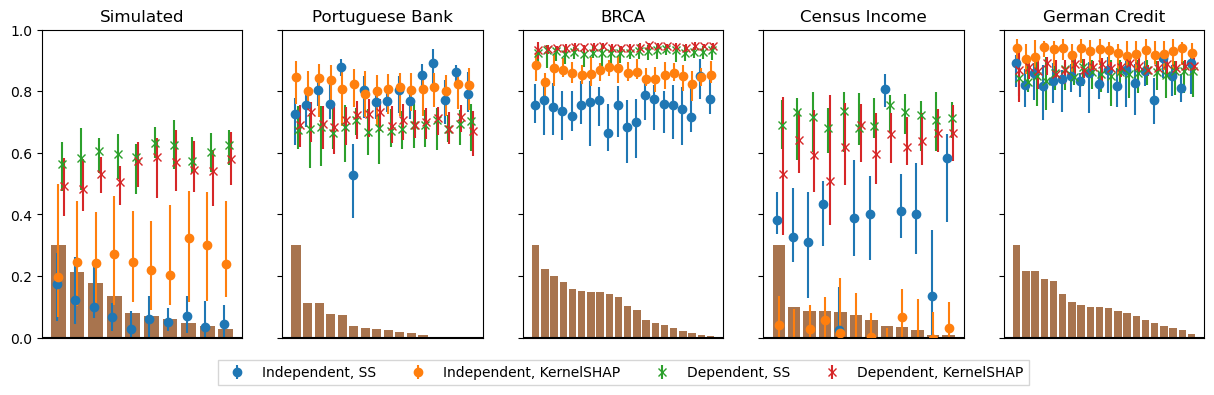

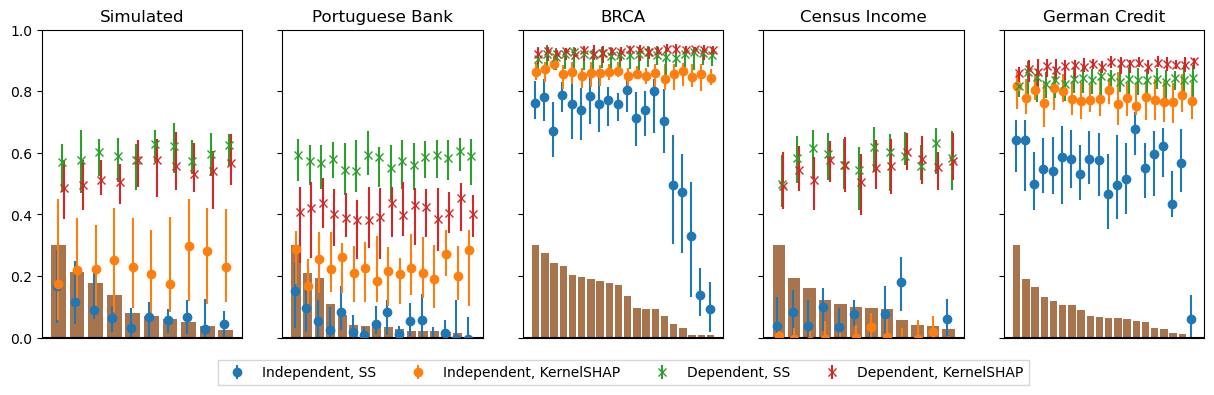

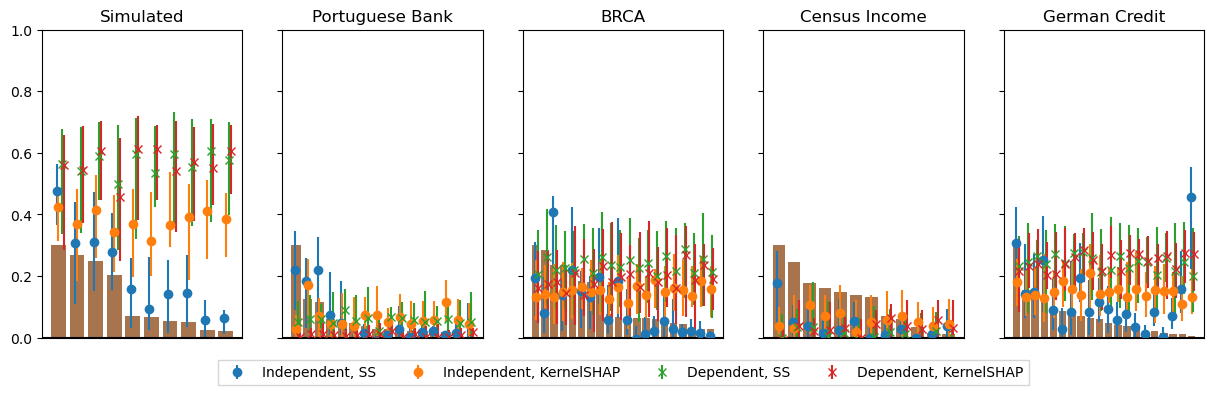

In [4]:
for method in methods:
    fig, ax = plt.subplots(nrows=1, ncols=len(dataset_names), figsize=(15,4))
    # method_idx = 0
    for data_idx in range(len(dataset_names)):
        folder = "Results_rf_cm_Oct08" if method=="rf" else "results_Oct6"
        fname = '../' + folder + '/' + datasets[data_idx] + '_' + method

        # #pts x #iters x #outputs x #features
        kshaps_indep = np.array(np.load(fname+'_kshap_indep.npy'))
        sss_indep = np.array(np.load(fname+'_ss_indep.npy'))
        kshaps_dep = np.array(np.load(fname+'_kshap_dep.npy'))
        sss_dep = np.array(np.load(fname+'_ss_dep.npy'))

        n_pts, nsim_per_point, h, d = kshaps_dep.shape

        means_kshap_dep = np.mean(kshaps_dep,axis=1)
        means_kshap_indep = np.mean(kshaps_indep,axis=1)
        vars_kshap_dep = np.var(kshaps_dep,axis=1)
        vars_kshap_indep = np.var(kshaps_indep,axis=1)

        means_ss_dep = np.mean(sss_dep,axis=1)
        means_ss_indep = np.mean(sss_indep,axis=1)
        vars_ss_dep = np.var(sss_dep,axis=1)
        vars_ss_indep = np.var(sss_indep,axis=1)

        # Both SS and KernelSHAP
        var_reducs_indep = 1-np.array([[vars_ss_indep[i][0]/vars_ss_indep[i][1] for i in range(n_pts)],
                            #[vars_kshap_indep[i][2]/vars_kshap_indep[i][0] for i in range(n_pts)],
                            [vars_kshap_indep[i][6]/vars_kshap_indep[i][0] for i in range(n_pts)]])

        # Two rows
        reducs_indep_25 = np.quantile(var_reducs_indep,0.25,axis=1).T
        reducs_indep_50 = np.quantile(var_reducs_indep,0.50,axis=1).T
        reducs_indep_75 = np.quantile(var_reducs_indep,0.75,axis=1).T

        var_reducs_dep = 1-np.array([[vars_ss_dep[i][0]/vars_ss_dep[i][1] for i in range(n_pts)],
                            #[vars_kshap_dep[i][2]/vars_kshap_dep[i][0] for i in range(n_pts)],
                            [vars_kshap_dep[i][6]/vars_kshap_dep[i][0] for i in range(n_pts)]])
        reducs_dep_25 = np.quantile(var_reducs_dep,0.25,axis=1).T
        reducs_dep_50 = np.quantile(var_reducs_dep,0.50,axis=1).T
        reducs_dep_75 = np.quantile(var_reducs_dep,0.75,axis=1).T

        xpts1 = np.arange(0,d) - 0.2
        xpts2 = np.arange(0,d) - 0.1
        xpts3 = np.arange(0,d) + 0.1
        xpts4 = np.arange(0,d) + 0.2
        yerr_indep_ss = np.array([reducs_indep_50[:,0]-reducs_indep_25[:,0],reducs_indep_75[:,0]-reducs_indep_50[:,0]])
        yerr_indep_kshap = np.array([reducs_indep_50[:,1]-reducs_indep_25[:,1],reducs_indep_75[:,1]-reducs_indep_50[:,1]])
        yerr_dep_ss = np.array([reducs_dep_50[:,0]-reducs_dep_25[:,0],reducs_dep_75[:,0]-reducs_dep_50[:,0]])
        yerr_dep_kshap = np.array([reducs_dep_50[:,1]-reducs_dep_25[:,1],reducs_dep_75[:,1]-reducs_dep_50[:,1]])

        global_shap_indep = np.sum(np.abs(np.mean(sss_indep, axis=1)[:,1,:]), axis=0)
        global_shap_indep_scaled = global_shap_indep/np.max(global_shap_indep)*0.3
        order_indep = np.argsort(global_shap_indep_scaled)[::-1]

        A = ax[data_idx].errorbar(xpts1,reducs_indep_50[order_indep,0],yerr=yerr_indep_ss[:,order_indep],fmt='o')
        B = ax[data_idx].errorbar(xpts2,reducs_indep_50[order_indep,1],yerr=yerr_indep_kshap[:,order_indep],fmt='o')
        C = ax[data_idx].errorbar(xpts3,reducs_dep_50[order_indep,0],yerr=yerr_dep_ss[:,order_indep],fmt='x')
        D = ax[data_idx].errorbar(xpts4,reducs_dep_50[order_indep,1],yerr=yerr_dep_kshap[:,order_indep],fmt='x')
        if data_idx==2:
            ax[data_idx].legend(["Independent, SS", "Independent, KernelSHAP", "Dependent, SS", "Dependent, KernelSHAP"], loc='upper center',
                    bbox_to_anchor=(0.5, -.05), fancybox=False, ncol=4)
        ax[data_idx].bar(np.arange(d)-.1,global_shap_indep_scaled[order_indep], alpha=0.75, color="saddlebrown")

        ax[data_idx].set_ylim([0,1])
        ax[data_idx].axhline(y=0,color='black')
        ax[data_idx].set_title(dataset_names[data_idx])

        # plt.xticks(np.arange(d), colnames[order_indep], rotation=60)
        if data_idx > 0:
            ax[data_idx].set_yticklabels([])
        ax[data_idx].set_xticks([])
        
    plt.show()



## Basic plot

In [5]:
import pandas as pd
import sage
df = sage.datasets.credit()
# Property, other installment, housing, job, status of checking act, credit history, purpose, savings, employment since, marital status, old debtors
n = df.shape[0]
X_df = df.drop(["Good Customer"], axis=1)
colnames = np.array(X_df.columns)#.to_list()
colnames[colnames=="Other Installment Plans"] = "Other Plans"
colnames[colnames=="Savings Account/Bonds"] = "Savings"
colnames[colnames=="Number Existing Credits"] = "Existing Credits"
colnames[colnames=="Housing Ownership"] = "Housing"
colnames[colnames=="Employment Since"] = "Employment"
colnames[colnames=="Debtors/Guarantors"] = "Debtors"
colnames[colnames=="Residence Duration"] = "Residence"
print(colnames)

['Checking Status' 'Duration' 'Credit History' 'Purpose' 'Credit Amount'
 'Savings' 'Employment' 'Installment Rate' 'Personal Status' 'Debtors'
 'Residence' 'Property Type' 'Age' 'Other Plans' 'Housing'
 'Existing Credits' 'Job' 'Number Liable' 'Telephone' 'Foreign Worker']


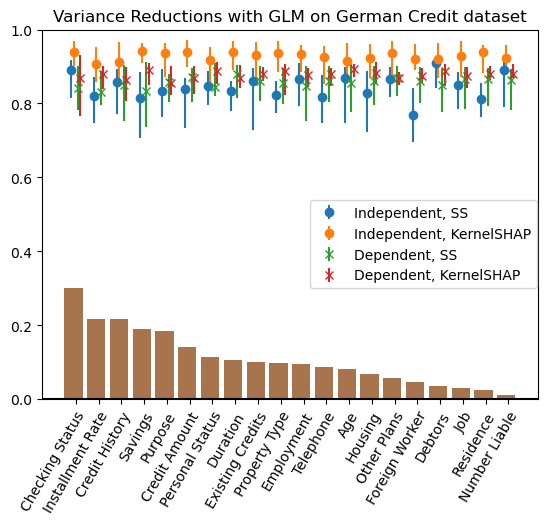

In [6]:
data_idx = 4
method_idx = 0
method = methods[method_idx]
folder = "Results_rf_cm_Oct08" if method=="rf" else "results_Oct6"
fname = '../' + folder + '/' + datasets[data_idx] + '_' + method

# fname = '../results_Oct6/' + datasets[data_idx] + '_' + methods[method_idx]

# #pts x #iters x #outputs x #features
kshaps_indep = np.array(np.load(fname+'_kshap_indep.npy'))
sss_indep = np.array(np.load(fname+'_ss_indep.npy'))
kshaps_dep = np.array(np.load(fname+'_kshap_dep.npy'))
sss_dep = np.array(np.load(fname+'_ss_dep.npy'))

n_pts, nsim_per_point, h, d = kshaps_indep.shape

means_kshap_dep = np.mean(kshaps_dep,axis=1)
means_kshap_indep = np.mean(kshaps_indep,axis=1)
vars_kshap_dep = np.var(kshaps_dep,axis=1)
vars_kshap_indep = np.var(kshaps_indep,axis=1)

means_ss_dep = np.mean(sss_dep,axis=1)
means_ss_indep = np.mean(sss_indep,axis=1)
vars_ss_dep = np.var(sss_dep,axis=1)
vars_ss_indep = np.var(sss_indep,axis=1)

# Both SS and KernelSHAP
var_reducs_indep = 1-np.array([[vars_ss_indep[i][0]/vars_ss_indep[i][1] for i in range(n_pts)],
                    #[vars_kshap_indep[i][2]/vars_kshap_indep[i][0] for i in range(n_pts)],
                    [vars_kshap_indep[i][6]/vars_kshap_indep[i][0] for i in range(n_pts)]])

# Two rows
reducs_indep_25 = np.quantile(var_reducs_indep,0.25,axis=1).T
reducs_indep_50 = np.quantile(var_reducs_indep,0.50,axis=1).T
reducs_indep_75 = np.quantile(var_reducs_indep,0.75,axis=1).T

var_reducs_dep = 1-np.array([[vars_ss_dep[i][0]/vars_ss_dep[i][1] for i in range(n_pts)],
                    #[vars_kshap_dep[i][2]/vars_kshap_dep[i][0] for i in range(n_pts)],
                    [vars_kshap_dep[i][6]/vars_kshap_dep[i][0] for i in range(n_pts)]])
reducs_dep_25 = np.quantile(var_reducs_dep,0.25,axis=1).T
reducs_dep_50 = np.quantile(var_reducs_dep,0.50,axis=1).T
reducs_dep_75 = np.quantile(var_reducs_dep,0.75,axis=1).T

xpts1 = np.arange(0,d) - 0.2
xpts2 = np.arange(0,d) - 0.1
xpts3 = np.arange(0,d) + 0.1
xpts4 = np.arange(0,d) + 0.2
yerr_indep_ss = np.array([reducs_indep_50[:,0]-reducs_indep_25[:,0],reducs_indep_75[:,0]-reducs_indep_50[:,0]])
yerr_indep_kshap = np.array([reducs_indep_50[:,1]-reducs_indep_25[:,1],reducs_indep_75[:,1]-reducs_indep_50[:,1]])
yerr_dep_ss = np.array([reducs_dep_50[:,0]-reducs_dep_25[:,0],reducs_dep_75[:,0]-reducs_dep_50[:,0]])
yerr_dep_kshap = np.array([reducs_dep_50[:,1]-reducs_dep_25[:,1],reducs_dep_75[:,1]-reducs_dep_50[:,1]])

global_shap_indep = np.sum(np.abs(np.mean(sss_indep, axis=1)[:,1,:]), axis=0)
global_shap_indep_scaled = global_shap_indep/np.max(global_shap_indep)*0.3
order_indep = np.argsort(global_shap_indep_scaled)[::-1]

A = plt.errorbar(xpts1,reducs_indep_50[order_indep,0],yerr=yerr_indep_ss[:,order_indep],fmt='o')
B = plt.errorbar(xpts2,reducs_indep_50[order_indep,1],yerr=yerr_indep_kshap[:,order_indep],fmt='o')
C = plt.errorbar(xpts3,reducs_dep_50[order_indep,0],yerr=yerr_dep_ss[:,order_indep],fmt='x')
D = plt.errorbar(xpts4,reducs_dep_50[order_indep,1],yerr=yerr_dep_kshap[:,order_indep],fmt='x')
plt.legend(["Independent, SS", "Independent, KernelSHAP", "Dependent, SS", "Dependent, KernelSHAP"], loc=[.54,.3]) #'upper right'
plt.bar(np.arange(d)-.1,global_shap_indep_scaled[order_indep], alpha=0.75, color="saddlebrown")

plt.ylim([0,1])
plt.axhline(y=0,color='black')

plt.title("Variance Reductions with "+method_names[method_idx]+" on "+dataset_names[data_idx] + " dataset")

# df_orig = sage.datasets.bank()
# colnames = df_orig.columns[:(df_orig.shape[1]-1)]
plt.xticks(np.arange(d), colnames[order_indep], rotation=60, rotation_mode='anchor', ha="right")
# plt.xticks([])
plt.show()



## Variance Reductions across KernelSHAP Covariance Methods

[[ 0.80041969  0.79789806 -7.89277195]
 [ 0.82178537  0.82380194 -8.77928921]
 [ 0.80667849  0.82139184 -7.18122932]
 [ 0.83602488  0.82637275 -7.64957744]
 [ 0.81365712  0.79804883 -7.68676365]
 [ 0.80501381  0.79232947 -1.0424781 ]
 [ 0.84583458  0.84948882 -6.4867182 ]
 [ 0.82346848  0.82134578 -3.12942369]
 [ 0.82139698  0.81190065 -0.04779115]
 [ 0.81228597  0.81330506 -0.33793544]
 [ 0.79109778  0.79018287 -5.43528498]
 [ 0.80685372  0.80489544 -5.54070535]
 [ 0.80163012  0.8039148  -5.54620828]
 [ 0.80000025  0.79422004 -1.55906332]
 [ 0.84164477  0.8429614  -0.71638514]
 [ 0.80794616  0.79958236 -0.21095295]]
[[ 0.30617088  0.30834384 -0.01231392]
 [ 0.2604928   0.25021989 -0.05252989]
 [ 0.30491593  0.31351474 -0.07594748]
 [ 0.25747915  0.25343315 -0.00494023]
 [ 0.2797403   0.27300045  0.00601395]
 [ 0.32686032  0.33289454  0.09277363]
 [ 0.33504969  0.33167189  0.18695824]
 [ 0.28332214  0.24783559  0.0444677 ]
 [ 0.27675418  0.27453796 -0.03164496]
 [ 0.26514147  0.2469329

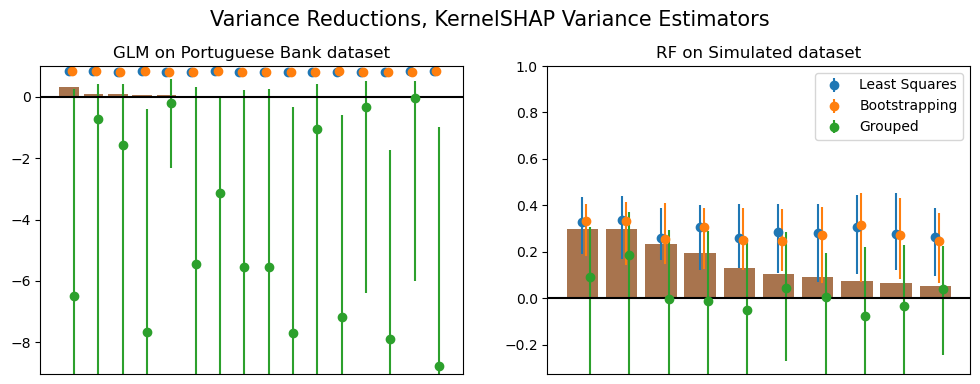

In [151]:
# data_idx = 1
# method_idx = 0
df_orig = sage.datasets.bank()
bank_colnames = df_orig.columns[:(df_orig.shape[1]-1)]

data_indices = [1,0]
method_indices = [0,2]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i in range(2): # dataset x ML method
    dataset = datasets[data_indices[i]]
    method = methods[method_indices[i]]

    fname = '../results_Oct6/' + dataset + '_' + method

    # #pts x #iters x #outputs x #features
    kshaps_indep = np.load(fname+'_kshap_indep.npy')
    kshaps_dep = np.load(fname+'_kshap_dep.npy')

    n_pts, nsim_per_point, h, d = kshaps_indep.shape

    kshaps_indep = np.array(kshaps_indep)
    vars_kshap_indep = np.nanvar(kshaps_indep,axis=1)

    var_reducs_indep = 1-np.array([[vars_kshap_indep[i][6]/vars_kshap_indep[i][0] for i in range(n_pts)],
                        [vars_kshap_indep[i][2]/vars_kshap_indep[i][0] for i in range(n_pts)],
                        [vars_kshap_indep[i][4]/vars_kshap_indep[i][0] for i in range(n_pts)]])

    # Three rows
    reducs_indep_25 = np.quantile(var_reducs_indep,0.25,axis=1).T
    reducs_indep_50 = np.quantile(var_reducs_indep,0.50,axis=1).T
    reducs_indep_75 = np.quantile(var_reducs_indep,0.75,axis=1).T
    print(reducs_indep_50)
    xpts1 = np.arange(0,d) - 0.1
    xpts2 = np.arange(0,d)
    xpts3 = np.arange(0,d) + 0.1
    yerr_kshap_ls = np.array([reducs_indep_50[:,0]-reducs_indep_25[:,0],reducs_indep_75[:,0]-reducs_indep_50[:,0]])
    yerr_kshap_boot = np.array([reducs_indep_50[:,1]-reducs_indep_25[:,1],reducs_indep_75[:,1]-reducs_indep_50[:,1]])
    yerr_kshap_grouped = np.array([reducs_indep_50[:,2]-reducs_indep_25[:,2],reducs_indep_75[:,2]-reducs_indep_50[:,2]])

    global_shap_indep = np.sum(np.abs(np.mean(kshaps_indep, axis=1)[:,1,:]), axis=0)
    global_shap_indep_scaled = global_shap_indep/np.max(global_shap_indep)*0.3
    order_indep = np.argsort(global_shap_indep_scaled)[::-1]

    A = ax[i].errorbar(xpts1,reducs_indep_50[order_indep,0],yerr=yerr_kshap_ls[:,order_indep],fmt='o')
    B = ax[i].errorbar(xpts2,reducs_indep_50[order_indep,1],yerr=yerr_kshap_boot[:,order_indep],fmt='o')
    # plt.legend(["Least Squares", "Bootstrapping"], loc='upper right')

    C = ax[i].errorbar(xpts3,reducs_indep_50[order_indep,2],yerr=yerr_kshap_grouped[:,order_indep],fmt='o')
    plt.legend(["Least Squares", "Bootstrapping", "Grouped"], loc='upper right')

    ax[i].bar(np.arange(d)-.1,global_shap_indep_scaled[order_indep], alpha=0.75, color="saddlebrown")

    ax[i].set_ylim([min(0,np.min(reducs_indep_50-.25)),1])
    # ax[i].set_ylim([0,1])
    ax[i].axhline(y=0,color='black')
    # fig.suptitle("Variance Reductions, KernelSHAP Variance Estimators")
    ax[i].set_title(method_names[method_indices[i]]+" on "+dataset_names[data_indices[i]] + " dataset")
    ax[i].set_xticks([])
plt.suptitle("Variance Reductions, KernelSHAP Variance Estimators", y=1.02, fontsize=15)
plt.show()
#var reducs, theo vs est


### Grouped Post-Mortem
- Correlation often -1 (?) or 1

0.9120979341009223
0.662442403275846


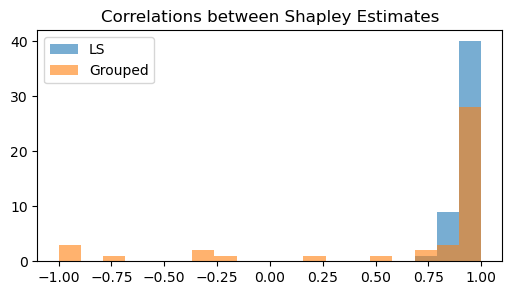

In [116]:
dataset = "bank"
method = "glm"

fname = '../results_Oct6/' + dataset + '_' + method
kshaps_indep = np.array(np.load(fname+'_kshap_indep.npy'))

pt_idx = 10
feat_idx = np.argsort(np.abs(kshaps_indep[pt_idx,0,6]))[::-1][0] # Most important feature, at least on point 0

n_pts, nsim_per_point, h, d = kshaps_indep.shape
corrs_ls = kshaps_indep[pt_idx,:,7, feat_idx] # Point 10, Feature index 0, 
corrs_grouped = kshaps_indep[pt_idx,:,5, feat_idx]
print(np.mean(corrs_ls))
print(np.nanmean(corrs_grouped))
##########
plt.figure(figsize=(6,3))
ax = plt.gca()
bins = np.linspace(np.nanmin([corrs_ls, corrs_grouped]), np.nanmax([corrs_ls, corrs_grouped]),20)

ax.hist(corrs_ls.reshape(-1), alpha=.6, bins=bins)
ax.hist(corrs_grouped.reshape(-1), alpha=.6, bins=bins)
plt.title("Correlations between Shapley Estimates")
plt.legend(["LS", "Grouped"], loc="upper left")
plt.show()

[-0.24206364 -0.22086968 -0.19967573 -0.17848177 -0.15728781 -0.13609386
 -0.1148999  -0.09370595 -0.07251199 -0.05131804 -0.03012408 -0.00893013
  0.01226383  0.03345779  0.05465174  0.0758457   0.09703965  0.11823361
  0.13942756  0.16062152]


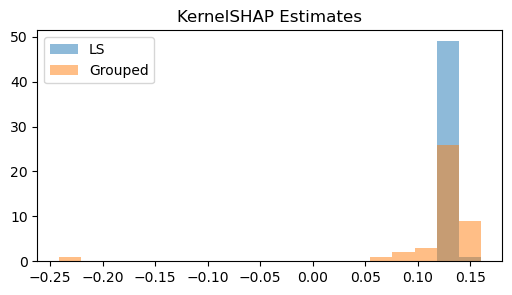

In [114]:
# pt_idx=0
ests_ls = kshaps_indep[pt_idx,:,6, feat_idx] # Point 10, Feature index 0, 
ests_grouped = kshaps_indep[pt_idx,:,4, feat_idx]
ests_vanilla = kshaps_indep[pt_idx,:,0, feat_idx]
bins = np.linspace(np.nanmin([ests_grouped, ests_vanilla]), np.nanmax([ests_grouped, ests_vanilla]),20)
print(bins)
plt.figure(figsize=(6,3))
ax = plt.gca()
ax.hist(ests_ls.reshape(-1), alpha=.5, bins=bins)
# ax.hist(ests_vanilla.reshape(-1), alpha=.5)
ax.hist(ests_grouped.reshape(-1), alpha=.5, bins=bins)
plt.title("KernelSHAP Estimates")
plt.legend(["LS", "Grouped"], loc="upper left")
plt.show()


- NA roughly 17\% of the time

In [129]:
kshaps_grouped = kshaps_indep[:,:,4, :]
np.sum(np.isnan(kshaps_grouped))/kshaps_grouped.reshape(-1).shape[0]

0.1665

## Do squared correlations really indicate variance reductions?
### KernelSHAP, LS

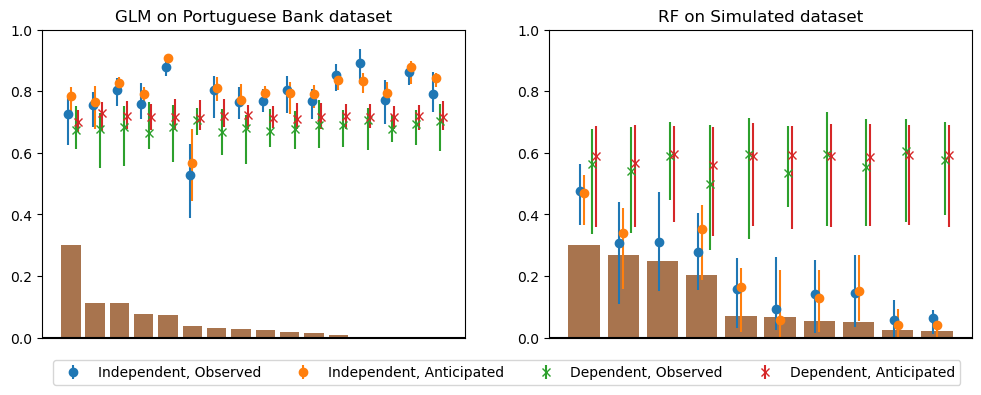

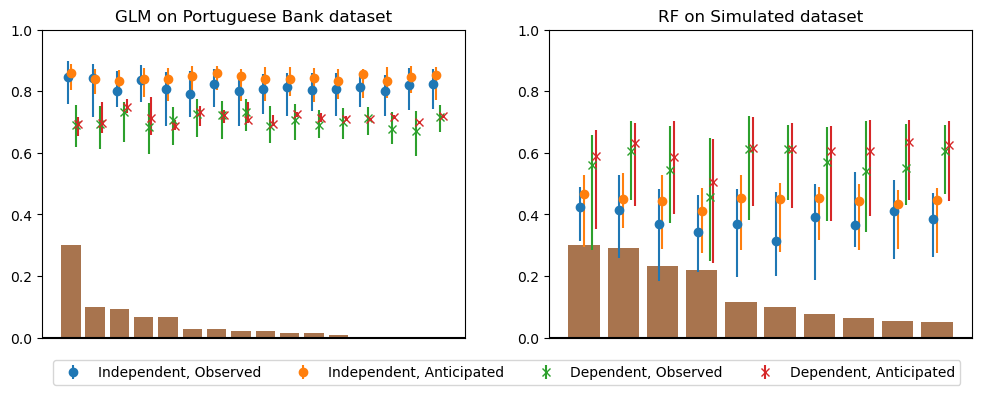

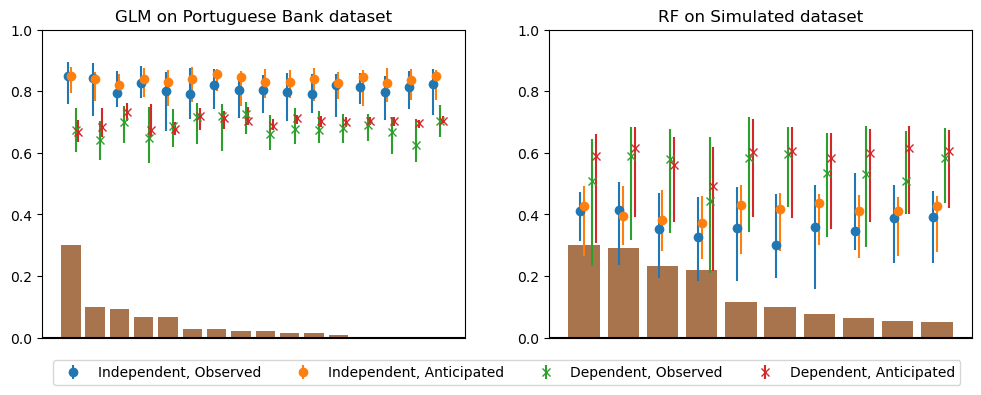

In [7]:
data_indices = [1,0]
method_indices = [0,2]
for idx in range(3):  # Shapley sampling vs KernelSHAP (bootstrapped + LS)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    for i in range(2): # dataset x ML method
        dataset = datasets[data_indices[i]]
        method = methods[method_indices[i]]
        folder = "Results_rf_cm_Oct08" if method=="rf" else "results_Oct6"
        fname = '../' + folder + '/' + dataset + '_' + method

        # #pts x #iters x #outputs x #features
        kshaps_indep = np.array(np.load(fname+'_kshap_indep.npy'))
        sss_indep = np.array(np.load(fname+'_ss_indep.npy'))
        kshaps_dep = np.array(np.load(fname+'_kshap_dep.npy'))
        sss_dep = np.array(np.load(fname+'_ss_dep.npy'))
        n_pts, nsim_per_point, h, d = kshaps_indep.shape
        if idx==0:
            avg_corrs_indep = np.mean(sss_indep[:,:,3,:], axis=1)
            avg_corrs_dep = np.mean(sss_dep[:,:,3,:], axis=1)
            vars_ss_indep = np.var(sss_indep,axis=1)
            var_reducs_indep = 1-np.array([vars_ss_indep[i][0]/vars_ss_indep[i][1] for i in range(n_pts)])
            vars_ss_dep = np.var(sss_dep,axis=1)
            var_reducs_dep = 1-np.array([vars_ss_dep[i][0]/vars_ss_dep[i][1] for i in range(n_pts)])
            global_shap_indep = np.sum(np.abs(np.mean(sss_indep, axis=1)[:,1,:]), axis=0)
        else: 
            vars_kshap_indep = np.var(kshaps_indep,axis=1)
            vars_kshap_dep = np.var(kshaps_dep,axis=1)
            global_shap_indep = np.sum(np.abs(np.mean(kshaps_indep, axis=1)[:,1,:]), axis=0)

            if idx==1: # Least Squares
                avg_corrs_indep = np.mean(kshaps_indep[:,:,7,:], axis=1)
                avg_corrs_dep = np.mean(kshaps_dep[:,:,7,:], axis=1)
                var_reducs_indep = 1-np.array([vars_kshap_indep[i][6]/vars_kshap_indep[i][0] for i in range(n_pts)])
                var_reducs_dep = 1-np.array([vars_kshap_dep[i][6]/vars_kshap_dep[i][0] for i in range(n_pts)])
                
            else: # Bootstrapping
                avg_corrs_indep = np.mean(kshaps_indep[:,:,3,:], axis=1)
                avg_corrs_dep = np.mean(kshaps_dep[:,:,3,:], axis=1)
                var_reducs_indep = 1-np.array([vars_kshap_indep[i][2]/vars_kshap_indep[i][0] for i in range(n_pts)])
                var_reducs_dep = 1-np.array([vars_kshap_dep[i][2]/vars_kshap_dep[i][0] for i in range(n_pts)])

        reducs_indep_25 = np.quantile(var_reducs_indep,0.25,axis=0).T
        reducs_indep_50 = np.quantile(var_reducs_indep,0.50,axis=0).T
        reducs_indep_75 = np.quantile(var_reducs_indep,0.75,axis=0).T
        
        theo_indep_var_reducs = np.maximum(avg_corrs_indep, 0)**2
        reducs_indep_25b = np.quantile(theo_indep_var_reducs,0.25,axis=0).T
        reducs_indep_50b = np.quantile(theo_indep_var_reducs,0.50,axis=0).T
        reducs_indep_75b = np.quantile(theo_indep_var_reducs,0.75,axis=0).T

        reducs_dep_25 = np.quantile(var_reducs_dep,0.25,axis=0).T
        reducs_dep_50 = np.quantile(var_reducs_dep,0.50,axis=0).T
        reducs_dep_75 = np.quantile(var_reducs_dep,0.75,axis=0).T

        
        theo_dep_var_reducs = np.maximum(avg_corrs_dep, 0)**2
        reducs_dep_25b = np.quantile(theo_dep_var_reducs,0.25,axis=0).T
        reducs_dep_50b = np.quantile(theo_dep_var_reducs,0.50,axis=0).T
        reducs_dep_75b = np.quantile(theo_dep_var_reducs,0.75,axis=0).T

        xpts1 = np.arange(0,d) - 0.2
        xpts2 = np.arange(0,d) - 0.1
        xpts3 = np.arange(0,d) + 0.1
        xpts4 = np.arange(0,d) + 0.2

        yerr_obs_indep = np.array([reducs_indep_50-reducs_indep_25,reducs_indep_75-reducs_indep_50])
        yerr_theo_indep = np.array([reducs_indep_50b-reducs_indep_25b,reducs_indep_75b-reducs_indep_50b])
        yerr_obs_dep = np.array([reducs_dep_50-reducs_dep_25,reducs_dep_75-reducs_dep_50])
        yerr_theo_dep = np.array([reducs_dep_50b-reducs_dep_25b,reducs_dep_75b-reducs_dep_50b])

        global_shap_indep_scaled = global_shap_indep/np.max(global_shap_indep)*0.3
        order_indep = np.argsort(global_shap_indep_scaled)[::-1]

        A = ax[i].errorbar(xpts1,reducs_indep_50[order_indep],yerr=yerr_obs_indep[:,order_indep],fmt='o')
        B = ax[i].errorbar(xpts2,reducs_indep_50b[order_indep],yerr=yerr_theo_indep[:,order_indep],fmt='o')
        C = ax[i].errorbar(xpts3,reducs_dep_50[order_indep],yerr=yerr_obs_dep[:,order_indep],fmt='x')
        D = ax[i].errorbar(xpts4,reducs_dep_50b[order_indep],yerr=yerr_theo_dep[:,order_indep],fmt='x')

        if i==0:
            ax[i].legend(["Independent, Observed", "Independent, Anticipated", "Dependent, Observed", "Dependent, Anticipated"], ncol=4,
            loc="upper center", bbox_to_anchor=(1.1, -.05))
        ax[i].bar(np.arange(d)-.1,global_shap_indep_scaled[order_indep], alpha=0.75, color="saddlebrown")

        ax[i].set_ylim([0,1])
        ax[i].axhline(y=0,color='black')

        ax[i].set_title(method_names[method_indices[i]]+" on "+dataset_names[data_indices[i]] + " dataset")
        ax[i].set_xticks([])

    # fig.suptitle("KernelSHAP Variance Reductions, Anticipated vs Observed, LS", fontsize=15, y=1.03)

plt.show()

